# Brain Tumor MRI Dataset

This dataset contains 7023 images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary.

## Train the model

In [356]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [357]:
import zipfile
local_zip = '/content/drive/MyDrive/classification_of_diseases/Brain_Tumor_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [358]:
train_path = '/content/Training'
test_path = '/content/Testing'

In [359]:
class_names = {0: 'Glioma', 1: 'Meningioma', 2: 'Not Tumor', 3: 'Pituitary'}

batch_size = 32
epochs = 50
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_COLOR = 3
num_of_classes = 4

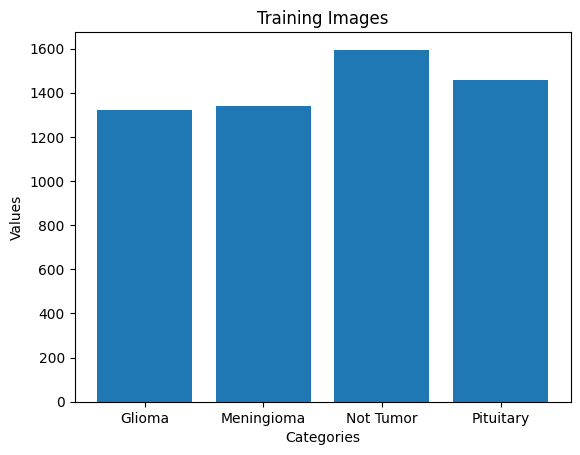

In [360]:
values = [1321, 1339, 1595, 1457]
categories = ['Glioma', 'Meningioma', 'Not Tumor', 'Pituitary']

plt.bar(categories, values)

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Training Images')

plt.show()

In [361]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=15, verbose=1)

# Checkpoints
checkpoint_filepath = '/content/drive/MyDrive/classification_of_diseases/brain_tumor_model.hdf5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, min_lr=1e-6)

In [362]:
rescale = 1./255

train_image_generator = ImageDataGenerator(rescale=rescale, 
                                           validation_split=0.2)

test_image_generator = ImageDataGenerator(rescale=rescale)

train_data_gen = train_image_generator.flow_from_directory(
        directory=train_path,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training', seed=6)

val_data_gen = train_image_generator.flow_from_directory(
        directory=train_path,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation', seed=6)

test_data_gen = test_image_generator.flow_from_directory(
        directory=test_path, 
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


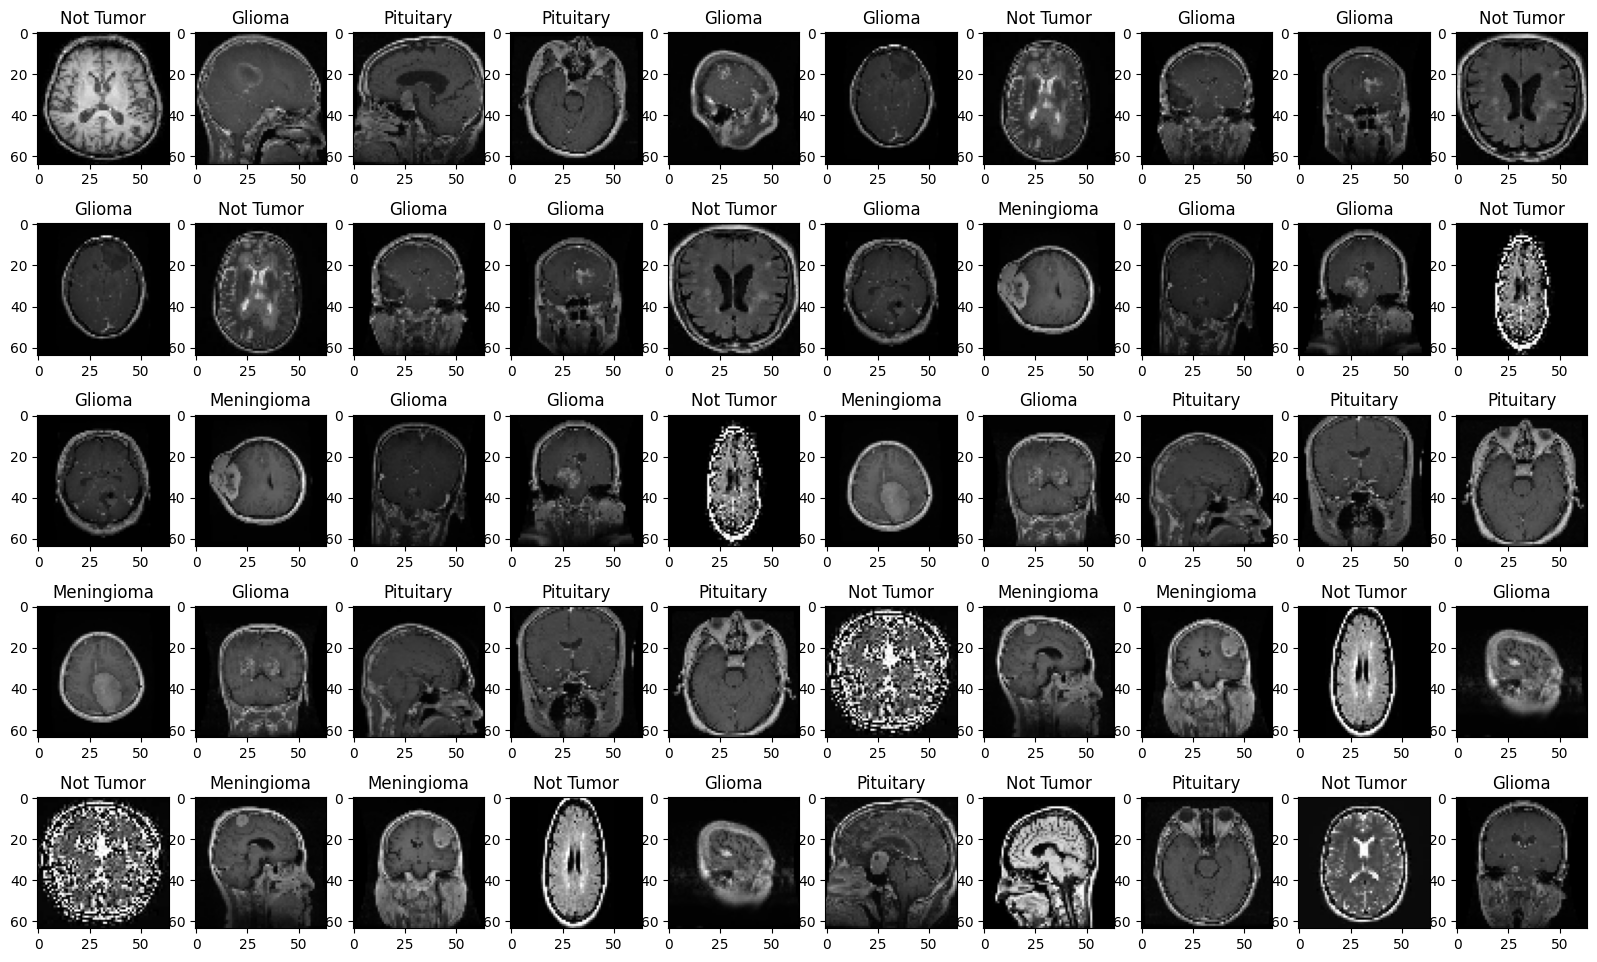

In [363]:
def plotImages(images_arr, labels_arr):
    fig, axes = plt.subplots(5, 10, figsize=(20, 12))

    for i in range(5):
        for j in range(10):
            img = images_arr[i * 5 + j]
            label = labels_arr[i * 5 + j]
            axes[i][j].imshow(img)
            #axes[i][j].axis('off')
            l = np.argmax(label)
            axes[i][j].set_title(class_names[l], fontsize=12)
    plt.show()

sample_training_images, sample_training_labels = next(train_data_gen)
plotImages(sample_training_images[:50], sample_training_labels[:50])

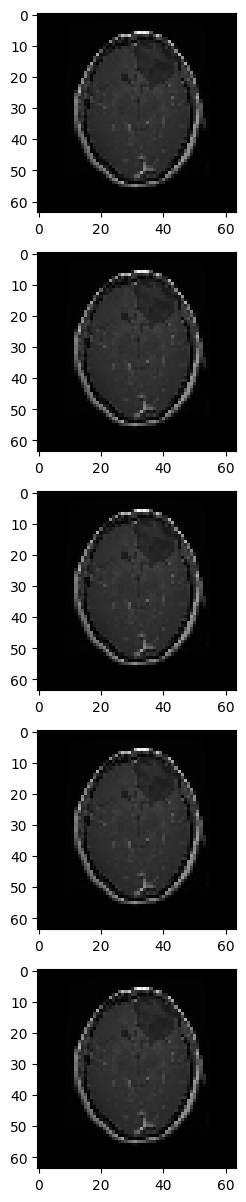

In [364]:
def plotAugmentedImages(images_arr):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))

    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.show()

n = 5 # Choose an image
augmented_images = [train_data_gen[0][0][n] for i in range(5)]
plotAugmentedImages(augmented_images)

In [365]:
import seaborn as sns

def plot_diagrams(history, h=16, w=6):
    epochs = len(history.history['loss'])
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(h, w))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [366]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (7, 7), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_COLOR)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (7, 7), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (7, 7), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_of_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [367]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 64, 64, 64)        9472      
                                                                 
 batch_normalization_55 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 32, 32, 128)       401536    
                                                                 
 batch_normalization_56 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                     

In [368]:
history = model.fit(x=train_data_gen, 
                    validation_data=val_data_gen, 
                    epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stopping, model_checkpoint, reduce_lr], verbose=1)

Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 1.1864 - accuracy: 0.6130
Epoch 1: val_loss improved from inf to 2.00847, saving model to /content/drive/MyDrive/classification_of_diseases/brain_tumor_model.hdf5
143/143 [==============================] - 19s 110ms/step - loss: 1.1864 - accuracy: 0.6130 - val_loss: 2.0085 - val_accuracy: 0.2673 - lr: 0.0010
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.7241
Epoch 2: val_loss did not improve from 2.00847
143/143 [==============================] - 15s 108ms/step - loss: 0.6797 - accuracy: 0.7241 - val_loss: 2.0679 - val_accuracy: 0.4417 - lr: 0.0010
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.5580 - accuracy: 0.8011
Epoch 3: val_loss improved from 2.00847 to 1.03492, saving model to /content/drive/MyDrive/classification_of_diseases/brain_tumor_model.hdf5
143/143 [==============================] - 18s 127ms/step - loss: 0.5580 - accuracy: 0.8011 -

In [369]:
train_loss, train_acc = model.evaluate(train_data_gen, verbose=2)
print("Train accuracy: " + "{:.2f}".format(train_acc*100) + "%")

143/143 - 10s - loss: 0.0409 - accuracy: 0.9884 - 10s/epoch - 72ms/step
Train accuracy: 98.84%


## Evaluate the model

In [370]:
test_loss, test_acc = model.evaluate(test_data_gen, verbose=2)
print("Test accuracy: " + "{:.2f}".format(test_acc*100) + "%")

41/41 - 4s - loss: 0.1869 - accuracy: 0.9413 - 4s/epoch - 90ms/step
Test accuracy: 94.13%


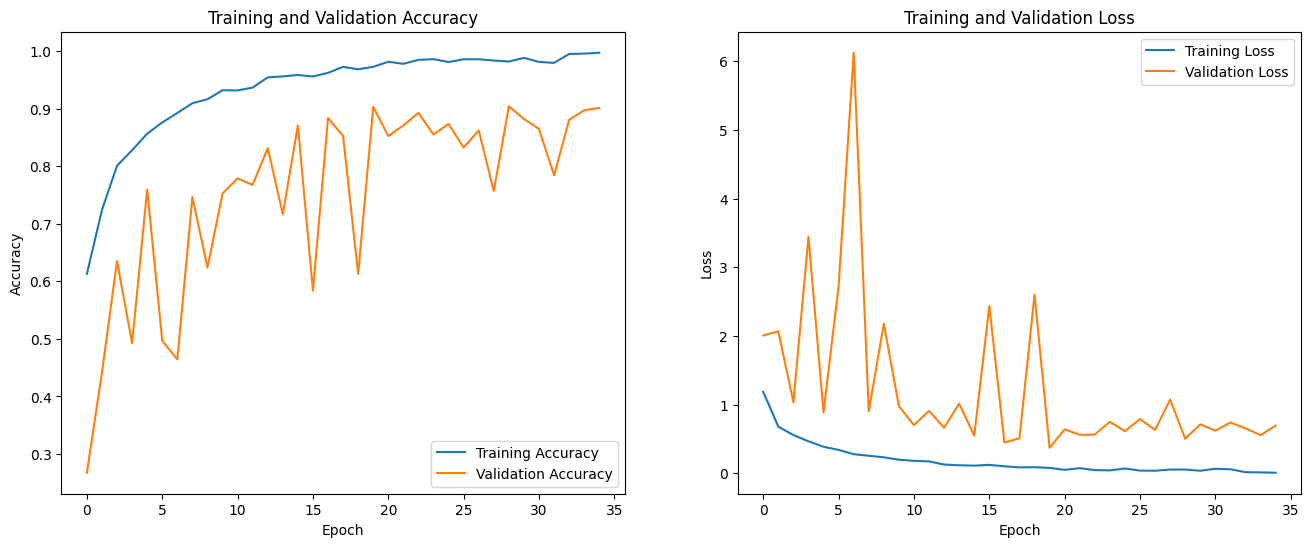

In [371]:
plot_diagrams(history)

41/41 [==============================] - 3s 60ms/step


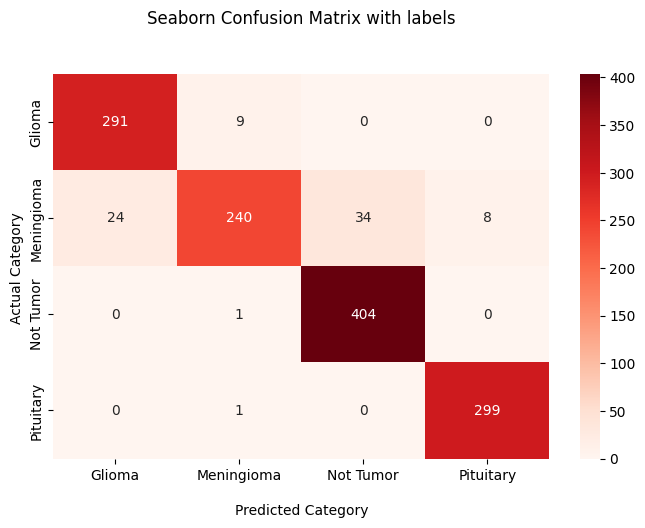

In [372]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, h=8, w=5):
    fig, ax = plt.subplots(figsize=(h, w))
    #Get the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds', fmt='d')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Category')
    ax.set_ylabel('Actual Category ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Glioma', 'Meningioma', 'Not Tumor', 'Pituitary'])
    ax.yaxis.set_ticklabels(['Glioma', 'Meningioma', 'Not Tumor', 'Pituitary'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

predicted_labels = model.predict(test_data_gen)
predicted_classes = np.argmax(predicted_labels, axis=1)
y_test = np.array(test_data_gen.labels)
plot_confusion_matrix(y_test, predicted_classes)

In [373]:
from sklearn.metrics import classification_report
report = classification_report(y_test, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       300
           1       0.96      0.78      0.86       306
           2       0.92      1.00      0.96       405
           3       0.97      1.00      0.99       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



## Load the model

In [374]:
from keras.models import load_model
best_model = load_model(checkpoint_filepath)

In [375]:
best_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 64, 64, 64)        9472      
                                                                 
 batch_normalization_55 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 32, 32, 128)       401536    
                                                                 
 batch_normalization_56 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                     

In [376]:
from keras.utils.layer_utils import count_params

trainable_params = count_params(best_model.trainable_weights)
non_trainable_params = count_params(best_model.non_trainable_weights)
print("Trainable params:", trainable_params)
print("Non trainable params:", non_trainable_params)

Trainable params: 6253764
Non trainable params: 896


In [377]:
train_loss, train_acc = best_model.evaluate(train_data_gen, verbose=2)
print("Train accuracy: " + "{:.2f}".format(train_acc*100) + "%")

143/143 - 11s - loss: 0.0409 - accuracy: 0.9884 - 11s/epoch - 75ms/step
Train accuracy: 98.84%


In [378]:
test_loss, test_acc = best_model.evaluate(test_data_gen, verbose=2)
print("Test accuracy: " + "{:.2f}".format(test_acc*100) + "%")

41/41 - 2s - loss: 0.1869 - accuracy: 0.9413 - 2s/epoch - 59ms/step
Test accuracy: 94.13%
